In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from scipy.integrate import odeint, solve_ivp

from dataset import Dataset

%load_ext autoreload
%autoreload 2

In [2]:
def mm(t, y, mu_max, Km, Y_XS):
    X = y[0]
    S = y[1]
    mu = mu_max * S / (Km + S)
    dydt = [mu * X, -1 / Y_XS * mu * X]
    return dydt

def contois(t, y, mu_max, A, Y_XS):
    X = y[0]
    S = y[1]
    mu = mu_max * S / (A*X + S)
    dydt = [mu * X, -1 / Y_XS * mu * X]
    return dydt

def substrate_inh(t, y, mu_max, Km, Ki, Y_XS):
    X = y[0]
    S = y[1]
    mu = mu_max * S / (Km + S + S**2/Ki)
    dydt = [mu * X, -1 / Y_XS * mu * X]
    return dydt

(8, 4)


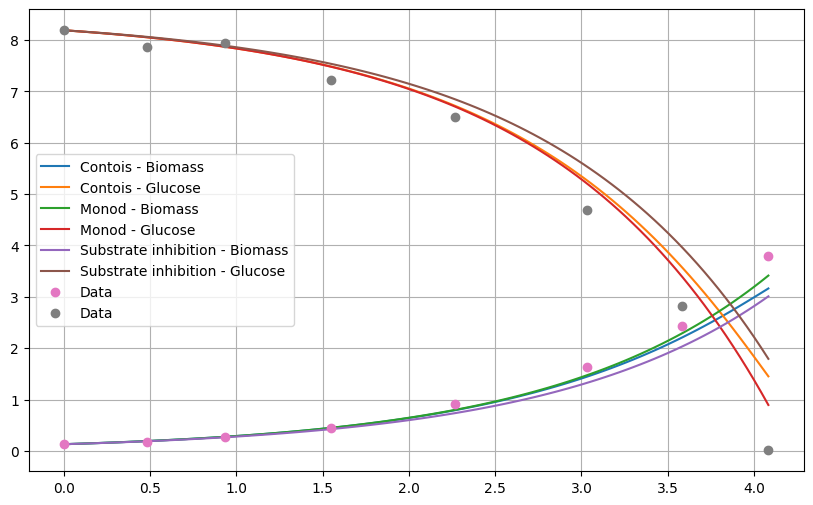

In [3]:
PATH_TO_DATA = '../data_ceasar.xlsx'
df = pd.read_excel(PATH_TO_DATA)
df = df[df['exp'] == 1]
y0 = [df['Biomass'].iloc[0], df['Glucose'].iloc[0]]
t_start = df['Time'].iloc[0]
t_end = df['Time'].iloc[-1]
print(df.shape)

t = np.linspace(t_start, t_end, 100)
mu_max = 0.8
Km = 0.002
Y_XS = 0.45
A = 0.1
Ki = 160

sol_contois = solve_ivp(contois, [t_start, t_end], y0, args=(mu_max, A, Y_XS), t_eval=t)
sol_mm = solve_ivp(mm, [t_start, t_end], y0, args=(mu_max, Km, Y_XS), t_eval=t)
sol_sub = solve_ivp(substrate_inh, [t_start, t_end], y0, args=(mu_max, Km, Ki, Y_XS), t_eval=t)

# Plot the solution
plt.figure(figsize=(10, 6))
plt.plot(sol_contois.t, sol_contois.y[0], label='Contois - Biomass')
plt.plot(sol_contois.t, sol_contois.y[1], label='Contois - Glucose')
plt.plot(sol_mm.t, sol_mm.y[0], label='Monod - Biomass')
plt.plot(sol_mm.t, sol_mm.y[1], label='Monod - Glucose')
plt.plot(sol_sub.t, sol_sub.y[0], label='Substrate inhibition - Biomass')
plt.plot(sol_sub.t, sol_sub.y[1], label='Substrate inhibition - Glucose')
plt.plot(df['Time'], df['Biomass'], 'o', label='Data')
plt.plot(df['Time'], df['Glucose'], 'o', label='Data')
plt.legend()
plt.grid(True)
plt.show()



In [141]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gstools import SRF, Gaussian
from gstools.random import MasterRNG

from scipy.integrate import odeint, solve_ivp

seed = MasterRNG(42)

T_START = 0
T_END = 5
N_SAMPLES = 100
N_CURVES = 50

def mm(t, y, mu_max, Km, Y_XS):
    X = y[0]
    S = y[1]
    mu = mu_max * S / (Km + S)
    dydt = [mu * X, -1 / Y_XS * mu * X]
    return dydt

def contois(t, y, mu_max, A, Y_XS):
    X = y[0]
    S = y[1]
    mu = mu_max * S / (A*X + S)
    dydt = [mu * X, -1 / Y_XS * mu * X]
    return dydt

def substrate_inh(t, y, mu_max, Km, Ki, Y_XS):
    X = y[0]
    S = y[1]
    mu = mu_max * S / (Km + S + S**2/Ki)
    dydt = [mu * X, -1 / Y_XS * mu * X]
    return dydt

t = np.linspace(T_START, T_END, N_SAMPLES)

S_X = np.zeros((N_SAMPLES, N_CURVES))
U_X = np.zeros((N_SAMPLES, N_CURVES))

S_S = np.zeros((N_SAMPLES, N_CURVES))
U_S = np.zeros((N_SAMPLES, N_CURVES))

for i in range(N_CURVES):
    mu_max = np.random.uniform(0.7,1)
    Km = np.random.uniform(0.001,0.1)
    Y_XS = np.random.uniform(0.1,1)
    y0 = [0.1, 8]
    sol = solve_ivp(mm, [T_START, T_END], y0, args=(mu_max, Km, Y_XS), t_eval=t)
    U_X[:,i] = sol.y[0].flatten()
    U_S[:,i] = sol.y[1].flatten()
    S_X[:,i] = mm(t, sol.y, mu_max, Km, Y_XS)[0]
    S_S[:,i] = mm(t, sol.y, mu_max, Km, Y_XS)[1]
    
print(f'U_X: {U_X.shape}, U_S: {U_S.shape}, S_X: {S_X.shape}, S_S: {S_S.shape}')

U_X: (100, 50), U_S: (100, 50), S_X: (100, 50), S_S: (100, 50)


In [154]:
# plt.figure(figsize=(10, 6))
# plt.plot(t, U_X[:,10], label='Biomass')
# plt.plot(t, U_S[:,10], label='Glucose')
# plt.plot(t, S_X[:,10], label='dBiomass')
# plt.plot(t, S_S[:,10], label='dGlucose')
# plt.legend()
# plt.show()

In [156]:
def iterate_data(m=N_SAMPLES, n=N_CURVES, x=t, U_S=U_S, U_X=U_X, S_S=S_S, S_X=S_X):
    us_S = np.zeros((m*n, m))
    us_X = np.zeros((m*n, m))
    ss_S = np.zeros((m*n, 1))
    ss_X = np.zeros((m*n, 1))
    ts = np.zeros((m*n, 1))
    for i in range(n):
        for j in range(m):
            us_S[i*m+j, :] = U_S[:,i]
            us_X[i*m+j, :] = U_X[:,i]
            ss_S[i*m+j, :] = S_S[j,i]
            ss_X[i*m+j, :] = S_X[j,i]
            ts[i*m+j, :] = x[j]
    return us_S, us_X, ss_S, ss_X, ts

us_S, us_X, ss_S, ss_X, ts = iterate_data()
print(f'us_S: {us_S.shape}, us_X: {us_X.shape}, ss_S: {ss_S.shape}, ss_X: {ss_X.shape}, ts: {ts.shape}')

us_S: (5000, 100), us_X: (5000, 100), ss_S: (5000, 1), ss_X: (5000, 1), ts: (5000, 1)


### DeepXDE for parameter estimation


In [100]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [12]:
df = pd.read_excel('../data_ceasar.xlsx')
df = df[df['exp']==1]
t_start = df['Time'].iloc[0]
t_end = df['Time'].iloc[-1]
X0 = df['Biomass'].iloc[0]
S0 = df['Glucose'].iloc[0]

In [107]:
mu_max = dde.Variable(0.5)
Km = dde.Variable(0.05)
Y_XS = dde.Variable(0.5)

geom = dde.geometry.TimeDomain(t_start, t_end)

def ode_system(t, y):
    X = y[:,0:1]
    S = y[:,1:2]
    mu = mu_max * S / (Km + S)
    dX_dt = dde.grad.jacobian(y, t, i=0)
    dS_dt = dde.grad.jacobian(y, t, i=1)
    return [
        dX_dt - mu * X,
        dS_dt + 1/Y_XS * mu * X
    ]
    
def boundary(_, on_initial):
    return on_initial

ic_X = dde.icbc.IC(geom, lambda x: X0, boundary, component=0)
ic_S = dde.icbc.IC(geom, lambda x: S0, boundary, component=1)

## Define the data
t_train = df['Time'].values.reshape(-1,1)
y_train = df[['Biomass', 'Glucose']].values

t0_train = dde.icbc.PointSetBC(t_train, y_train[:, 0:1], component=0)
s0_train = dde.icbc.PointSetBC(t_train, y_train[:, 1:2], component=1)

data = dde.data.PDE(
    geom,
    ode_system,
    [ic_X, ic_S, t0_train, s0_train],
    num_domain=100,
    num_boundary=2,
    anchors=t_train,
)

net = dde.nn.FNN([1] + [128] * 2 + [3], activation="tanh", kernel_initializer="Glorot normal")

model = dde.Model(data, net)
model.compile("adam", lr=0.001, external_trainable_variables=[mu_max, Km, Y_XS])
fnamevar = 'variables.dat'
variable = dde.callbacks.VariableValue([mu_max, Km, Y_XS], filename=fnamevar, period=100)
losshistory, train_state = model.train(epochs=10000, callbacks=[variable])

Compiling model...
Building feed-forward neural network...
'build' took 0.094550 s



/home/costasmexis/pyenvs/main/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.099954 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [6.66e-02, 3.60e-01, 1.70e-02, 6.71e+01, 6.20e+00, 3.72e+01]    [6.66e-02, 3.60e-01, 1.70e-02, 6.71e+01, 6.20e+00, 3.72e+01]    []  
1000      [9.06e-03, 2.25e-02, 7.44e-06, 1.93e-04, 3.01e-02, 5.58e-02]    [9.06e-03, 2.25e-02, 7.44e-06, 1.93e-04, 3.01e-02, 5.58e-02]    []  
2000      [1.53e-03, 1.12e-02, 7.74e-05, 1.17e-04, 7.31e-03, 2.00e-02]    [1.53e-03, 1.12e-02, 7.74e-05, 1.17e-04, 7.31e-03, 2.00e-02]    []  
3000      [1.80e-02, 3.71e-02, 1.31e-03, 1.84e-03, 6.94e-02, 1.57e-01]    [1.80e-02, 3.71e-02, 1.31e-03, 1.84e-03, 6.94e-02, 1.57e-01]    []  
4000      [6.92e-03, 1.20e-02, 2.51e-05, 1.35e-05, 2.13e-02, 3.32e-02]    [6.92e-03, 1.20e-02, 2.51e-05, 1.35e-05, 2.13e-02, 3.32e-02]    []  
5000      [2.51e-03, 6.38e-03, 9.89e-05, 3.64e-04, 8.44e-03, 1.54e-02]    [2.51e-03, 6.38

In [108]:
lines = open(fnamevar, "r").readlines()
last_line = lines[-1]
param_hat = np.fromstring(min(re.findall(re.escape("[")+r"(.*?)"+re.escape("]"), last_line), key=len), sep=',')
print(f'mu_max_hat: {param_hat[0]}, Km_hat: {param_hat[1]}, Y_XS_hat: {param_hat[2]}')

mu_max_hat: 0.785, Km_hat: 0.00494, Y_XS_hat: 0.441


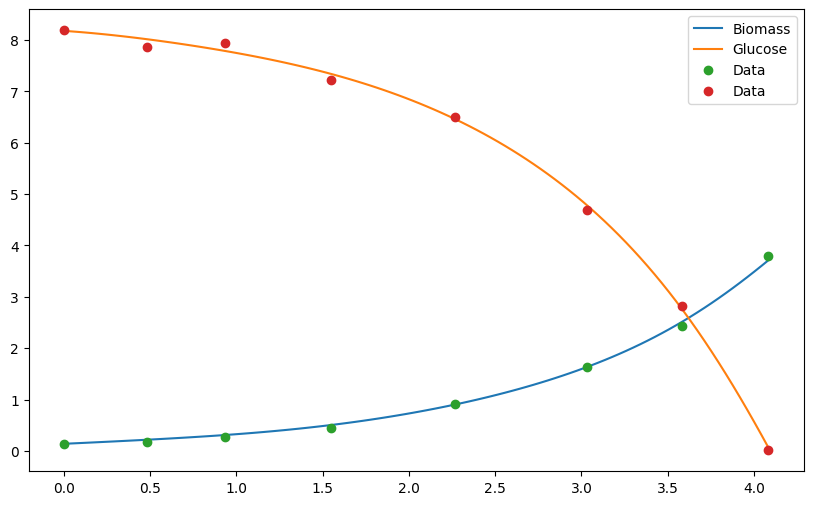

In [109]:
x = geom.uniform_points(100)
yhat = model.predict(x)

plt.figure(figsize=(10, 6))
plt.plot(x, yhat[:,0], label='Biomass')
plt.plot(x, yhat[:,1], label='Glucose')
plt.plot(df['Time'], df['Biomass'], 'o', label='Data')
plt.plot(df['Time'], df['Glucose'], 'o', label='Data')
plt.legend()
plt.show()